In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import seaborn as sns
sns.set_theme()
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.rcParams["font.family"] = "Times New Roman"

import mmtbx.f_model
import mmtbx.model
import cctbx.crystal
import cctbx.xray
import iotbx

sys.path.append(str(Path(Path.home(), "Documents/xray/src")))
# sys.path.append("../src")
import miller_ops
sys.path.append(str(Path(Path.home(), "Documents/xray/data/cifs/scripts")))
import generate_fmodel


In [31]:

data_dir = Path(Path.home(), "Documents/xray/sample_bench/data/7mhf/189_exp_ref_10000")
summary_file = Path(Path(data_dir, "summary_best.csv"))
summary_cif_dir = Path(Path(data_dir, "summary_best_cif"))

summary_df = pd.read_csv(summary_file, index_col=0)
summary_df["f_obs"] = np.NaN
summary_df["f_model"] = np.NaN

all_f_obs = list()
all_f_model = list()
all_flags = list()

summary_df.head()

,r_free_7mhf,ff,pdb,xray_7mhf,w_0_7mhf,N,J,job_id,r_free_7mhg,xray_7mhg,...,w_13_7mhk,w_14_7mhk,w_15_7mhk,exp_delta,ref_delta,ref_ff_delta,Unnamed: 117,Unnamed: 118,f_obs,f_model
198,0.279337,2424.053972,/wynton/group/sali/mhancock/xray/sample_bench/...,5.460668,0.49315,2,2,69,NaN,NaN,...,NaN,NaN,NaN,0.055337,-0.038176,1872.344068,0.279337,0.317513,NaN,NaN
238,NaN,3459.900325,/wynton/group/sali/mhancock/xray/sample_bench/...,NaN,NaN,2,3,87,0.264894,5.337109,...,NaN,NaN,NaN,0.059894,-0.032643,3103.627639,0.264894,0.297537,NaN,NaN
728,NaN,42194.112853,/wynton/group/sali/mhancock/xray/sample_bench/...,NaN,NaN,8,4,244,NaN,NaN,...,NaN,NaN,NaN,-0.055950,-0.105042,41283.840478,0.197050,0.302092,NaN,NaN
729,NaN,39311.353478,/wynton/group/sali/mhancock/xray/sample_bench/...,NaN,NaN,8,4,244,NaN,NaN,...,NaN,NaN,NaN,-0.044297,-0.099265,38271.464689,0.183703,0.282967,NaN,NaN
854,NaN,67768.896208,/wynton/group/sali/mhancock/xray/sample_bench/...,NaN,NaN,16,3,289,NaN,NaN,...,NaN,NaN,NaN,-0.047687,-0.104636,67326.354006,0.192313,0.296949,NaN,NaN


In [32]:
for index in summary_df.index:
    # pdb_entry = summary_df.loc[index, "pdb"]

    # cif_name = pdb_entry["cif_name"]
    N = summary_df.loc[index, "N"]
    J = summary_df.loc[index, "J"]

    cif_name = None
    for cif_name in ["7mhf", "7mhg", "7mhh", "7mhi", "7mhj", "7mhk"]:
        if not np.isnan(summary_df.loc[index, "xray_{}".format(cif_name)]):
            break

    f_obs_file = Path(Path.home(), "Documents/xray/data/cifs/7mhf/{}.cif".format(cif_name))
    f_obs = miller_ops.get_miller_array(
        f_obs_file=f_obs_file,
        label="_refln.F_meas_au"
    )
    f_obs = miller_ops.clean_miller_array(f_obs)
    status_array = miller_ops.get_miller_array(
        f_obs_file=f_obs_file,
        label="_refln.status"
    )
    flags = status_array.customized_copy(data=status_array.data()=="f")
    f_obs, flags = f_obs.common_sets(other=flags)

    f_model_file = Path(summary_cif_dir, "{}.cif".format(index))
    f_model = miller_ops.get_miller_array(
        f_obs_file=f_model_file,
        label="_refln.F_meas_au"
    )
    f_model = miller_ops.clean_miller_array(f_model)

    all_f_obs.append(f_obs)
    all_f_model.append(f_model)
    all_flags.append(flags)

    print(cif_name, N, J, f_obs.size(), f_model.size())

7mhf 2 2 37901 37901
7mhg 2 3 39941 39941
7mhh 8 4 14041 14041
7mhi 8 4 22275 22275
7mhj 16 3 18579 18579
7mhk 8 4 19435 19435


In [35]:
f_obs.select(flags.data())

crystal.symmetry(
    unit_cell=(114.3, 54.29, 44.97, 90, 102.12, 90),
    space_group_symbol="C 1 2 1"
  )
size: 879

In [41]:
refln_dfs = list()
for i in range(len(all_f_obs)):
    f_obs, f_model, flags = all_f_obs[i], all_f_model[i], all_flags[i]

    f_obs = f_obs.select(flags.data())
    f_model = f_model.select(flags.data())

    refl_df = pd.DataFrame(columns=["d", "f_obs", "f_model", "bin"])
    n_bins = 20
    f_obs.setup_binner(n_bins=n_bins)
    f_model.use_binning_of(f_obs)
    for i_bin in f_obs.binner().range_all():
        f_obs_bin = f_obs.select(f_obs.binner().selection(i_bin))
        f_model_bin = f_model.select(f_model.binner().selection(i_bin))

        n_reflns = len(f_obs_bin.data())

        refln_bin_df = pd.DataFrame()
        refln_bin_df["d"] = [f_obs_bin.d_spacings().data()[i] for i in range(n_reflns)]
        refln_bin_df["f_obs"] = [f for f in f_obs_bin.data()]
        refln_bin_df["f_model"] = [f for f in f_model_bin.data()]
        refln_bin_df["bin"] = [i_bin] * n_reflns

        refl_df = pd.concat([refl_df, refln_bin_df])

    refln_dfs.append(refl_df)

    # ax.set_xlim(1,10)
    # ax.set_ylim(0,1)



/var/folders/x2/ss4b83151c31mg5h31tlp3ym0000gn/T/ipykernel_5478/716067795.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  refl_df = pd.concat([refl_df, refln_bin_df])
/var/folders/x2/ss4b83151c31mg5h31tlp3ym0000gn/T/ipykernel_5478/716067795.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  refl_df = pd.concat([refl_df, refln_bin_df])
/var/folders/x2/ss4b83151c31mg5h31tlp3ym0000gn/T/ipykernel_5478/716067795.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA

In [47]:
r_factor_dfs = list()
for refln_df in refln_dfs:
    r_factor_df = pd.DataFrame()

    r_factor_num = 0
    r_factor_den = 0
    for i in range(1, n_bins):
        refln_bin_df = refln_df[refln_df["bin"] == i]
        for j in range(len(refln_bin_df)):
            r_factor_num += np.abs(refln_bin_df["f_obs"].iloc[j] - refln_bin_df["f_model"].iloc[j])
            r_factor_den += refln_bin_df["f_obs"].iloc[j]

        r_factor_df.loc[i, "d"] = np.min(refln_bin_df["d"])

        r_factor = r_factor_num / r_factor_den
        r_factor_df.loc[i, "r_factor"] = r_factor
        # print(r_factor)

    r_factor_dfs.append(r_factor_df)

    #     refln_df["error"] = (refln_df["f_obs"] - refln_df["f_model"]).abs()/refln_df["f_obs"]

    # refl_df = refl_df[refl_df.error != np.inf]
    # print(len(refl_df))


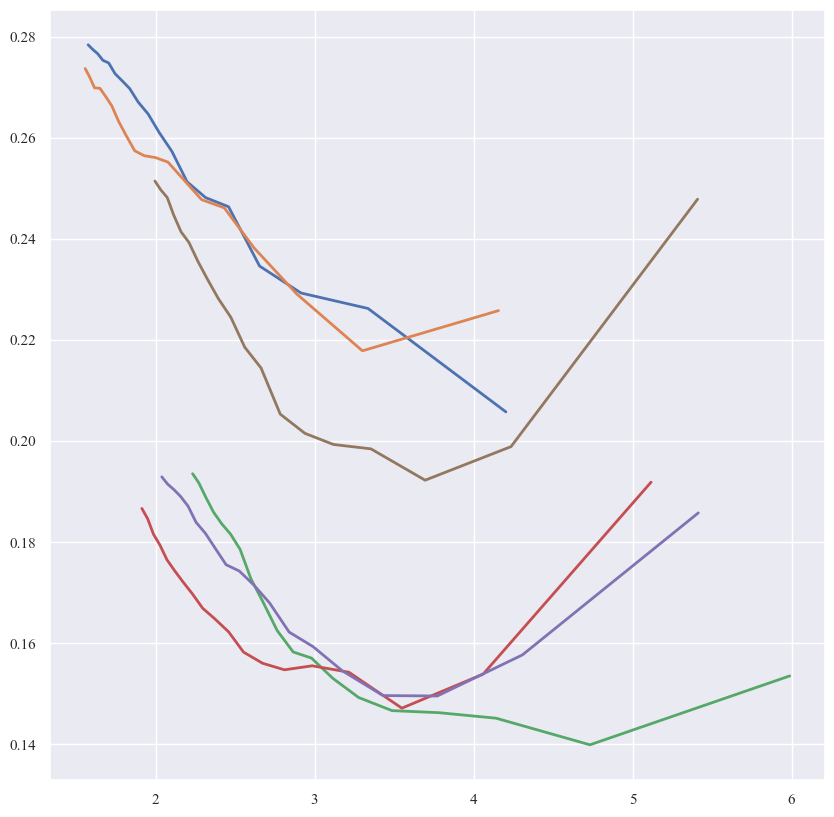

In [50]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

for r_factor_df in r_factor_dfs:
    ds, r_factors = r_factor_df["d"], r_factor_df["r_factor"]

    # plt.scatter(refl_df["d"], refl_df["error"], s=1)

    # for i in range(n_bins):
    #     refln_bin_df = refln_df[refln_df["bin"] == i]
    #     mean_errors.append(np.mean(refln_bin_df["error"]))

    #     mean_ds.append(np.mean(refln_bin_df["d"]))
    #     min_ds.append(np.min(refln_bin_df["d"]))
        # print(len(refln_bin_df))

    # print(min_ds)
    # print(mean_errors)
    plt.plot(r_factor_df["d"], r_factor_df["r_factor"], "-", linewidth=2)
    # plt.show()

# ax.tick_params(left=False, labelleft=False)
# ax.tick_params(bottom=False, labelbottom=False)
# plt.savefig(Path(Path.home(), "Desktop/fig.png"))